TODO: Move contents into make-figs.py for the paper after debugging.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import os
import sys

from openflash import *
# # --- Path Setup ---
# current_dir = os.getcwd()
# # for .py
# # current_dir = os.path.dirname(os.path.abspath(__file__))
# src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
# if src_dir not in sys.path:
#     sys.path.insert(0, src_dir)

# --- Import updated package modules ---
# from openflash.meem_engine import MEEMEngine
# from openflash.meem_problem import MEEMProblem
# from openflash.basic_region_geometry import BasicRegionGeometry
# from openflash.geometry import ConcentricBodyGroup
# from openflash.body import SteppedBody
# from openflash.multi_equations import *

In [3]:
# RM3
h = 70
d_list = [35, 3]
a_list = [3, 10]
heaving_list = [1, 0]
nmk = 100
exponents = np.linspace(-7, 3, 101)
m0s = list(10**exponents) + [np.inf]

def make_flat_geometry(h, d, a, heaving, NMK):
  bodies = [SteppedBody(a=np.array([a[i]]), d=np.array([d[i]]), slant_angle=np.array([0.0]), heaving=heaving[i]) for i in range(len(a))]
  return BasicRegionGeometry(body_arrangement=ConcentricBodyGroup(bodies), h=h, NMK=NMK)
  
NMK = [nmk, nmk, nmk]
frequencies = np.array([omega(m0, h, g) for m0 in m0s])
problem = MEEMProblem(make_flat_geometry(h, d_list, a_list, heaving_list, NMK))
problem.set_frequencies(frequencies)
engine = MEEMEngine(problem_list=[problem])

coeff_count = 5
er1ns = [[] for _ in range(coeff_count)]
added_masses = []
radiation_dampings = []
for m0 in m0s:
  X = engine.solve_linear_system_multi(problem, m0)
  hydros = engine.compute_hydrodynamic_coefficients(problem, X, m0)
  added_masses.append(hydros[1]["nondim_real"])
  radiation_dampings.append(hydros[1]["nondim_imag"])
  Cs = engine.reformat_coeffs(X, NMK, len(NMK) - 1)
  for i in range(coeff_count):
    er1ns[i].append(Cs[2][i]) # Store first coeff_count R1 coeffs in e region
er1ns_reals = [[np.real(entry) for entry in lst] for lst in er1ns]
er1ns_imags = [[np.imag(entry) for entry in lst] for lst in er1ns]

/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=9.77592e-19): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=9.93809e-19): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=1.01057e-18): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=1.0279e-18): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/meem_engine.py:283: LinAlgWarning: Ill-conditioned matrix (rcond=1.04584e-18): result may not be accurate.
  X = linalg.solve(A, b)
/Users/Bimali/Desktop/SEALab/OpenFLA

In [4]:
low_NMK = [1, 1, 1]
low_problem = MEEMProblem(make_flat_geometry(h, d_list, a_list, heaving_list, low_NMK))
low_problem.set_frequencies(frequencies)
low_engine = MEEMEngine(problem_list=[low_problem])

low_added_masses = []
low_radiation_dampings = []
for m0 in m0s:
  X = low_engine.solve_linear_system_multi(low_problem, m0)
  hydros = low_engine.compute_hydrodynamic_coefficients(low_problem, X, m0)
  low_added_masses.append(hydros[1]["nondim_real"])
  low_radiation_dampings.append(hydros[1]["nondim_imag"])

In [5]:
def plot_coeffs(m0s, float_coeffs, coeff_type):
  cmap = colormaps.get_cmap("inferno") #gnuplot
  colors = [cmap(1 - (0.1 + 0.8 * i / (coeff_count - 1))) for i in range(coeff_count)]
  plt.figure(figsize = (6, 6))
  for i in range(coeff_count):
    ys = [entry/float_coeffs[i][0] for entry in float_coeffs[i]]
    plt.plot(m0s, ys, label = fr'$C_{{{coeff_type}{i}}}^{{i_2}}$', color = colors[i])
  plt.xscale('log', base = 10)
  plt.xlabel("wavenumber")
  plt.ylabel("ratio of coefficient value to its value at wavenumber = 0.01")
  plt.legend()
  plt.show()

def plot_hydros(m0s, hydros, hydro_name, comparative = None):
  xs = m0s[:-1]
  ys = hydros[:-1]
  plt.figure(figsize = (6, 6))
  plt.plot(xs, ys, label = ("RM3 " + hydro_name), color = "blue")
  plt.hlines(hydros[-1], xs[0], xs[-1], label = ("RM3 " + hydro_name + " at infinite frequency"), color = "orange", linestyle = "--")
  if comparative is not None:
    plt.plot(xs[:len(comparative)], comparative, label = ("RM3 " + hydro_name + ", low wavenumber approximation"), color = "green", linestyle = ":")
  plt.xscale('log', base = 10)
  plt.xlabel("wavenumber")
  plt.ylabel("value")
  plt.title("RM3 " + hydro_name + " at high frequencies")
  plt.legend()
  plt.show()

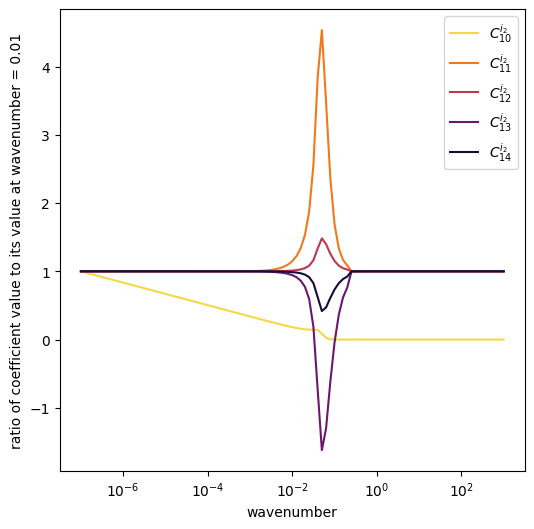

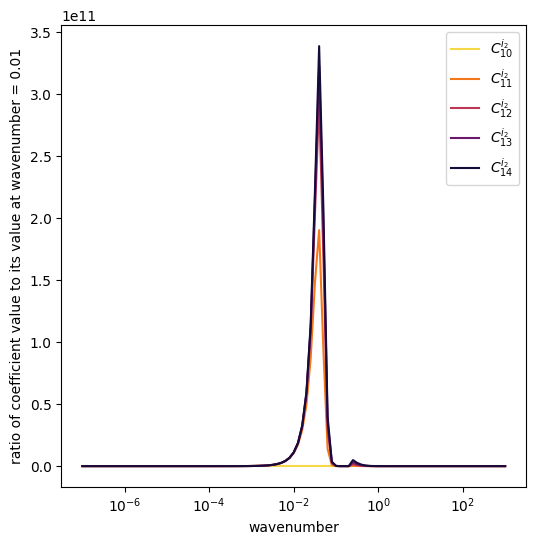

In [6]:
plot_coeffs(m0s, er1ns_reals, "1")
plot_coeffs(m0s, er1ns_imags, "1")

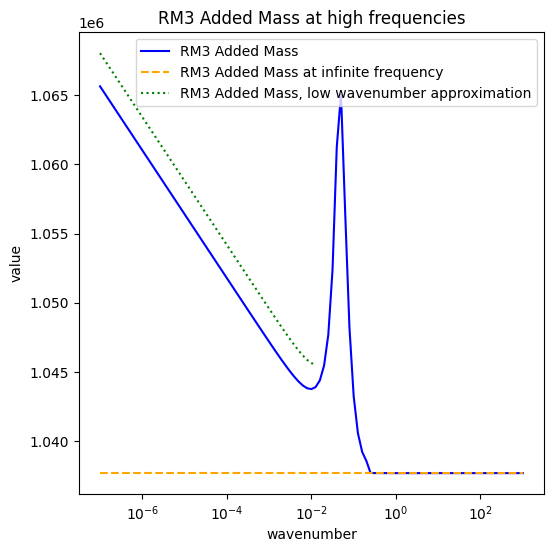

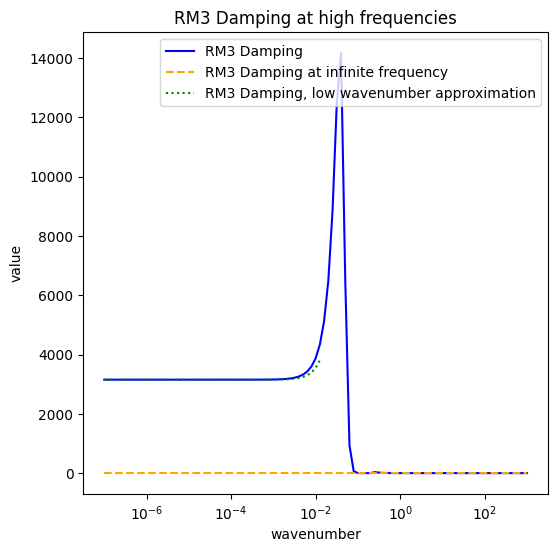

In [44]:
plot_hydros(m0s, added_masses, "Added Mass", low_added_masses[:52])
plot_hydros(m0s, radiation_dampings, "Damping", low_radiation_dampings[:52])